In [39]:
import pandas as pd
import torch 
import pickle
from torch import nn
import torchvision
import os
import numpy as np

In [2]:
train_img_csv = pd.read_csv('train_predictions_img.csv')
train_tab_csv = pd.read_csv('train_hm_tab_cluster.csv')
test_tab_csv = pd.read_csv('test_hm_tab_cluster.csv')
test_img_csv = pd.read_csv('test_predictions_img.csv')

In [3]:
df = pd.read_csv('data/h&mdataset/articles.csv')
df = df.drop(columns=['article_id','prod_name','product_code','product_type_no','department_no', 'index_code', 	
       'product_type_name', 'product_group_name',
       'graphical_appearance_name', 'colour_group_name', 'perceived_colour_value_name', 'perceived_colour_master_name', 'department_name', 'index_name', 'index_group_name', 'section_name', 'garment_group_name', 'detail_desc'])

In [4]:
from dataset import myDataset

get_preprocessed_image = True
train_test_split = 0.9
my_path_hm = os.path.join(os.getcwd(), 'data/h&mdataset/images/')
my_path_fash = os.path.join(os.getcwd(), 'data/fashion-dataset/images/')

dataset = myDataset(my_path_hm, my_path_fash, get_preprocessed_image, 'hm')

In [5]:
test_img_csv

,image,cluster
0,/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes...,1
1,/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes...,25
2,/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes...,1
3,/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes...,155
4,/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes...,1
...,...,...
10505,/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes...,1
10506,/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes...,1
10507,/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes...,1
10508,/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes...,1


In [6]:
#find common points in test img and tab

common_points = pd.merge(test_img_csv, test_tab_csv, left_on='image', right_on='img_name', how='inner')

In [7]:
common_points

,image,cluster_x,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,index_group_no,section_no,garment_group_no,cluster_y,img_name
0,/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes...,1,1010026,73,4,2,4,41,1005,197,/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes...
1,/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes...,68,1010016,42,5,18,2,53,1007,197,/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes...
2,/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes...,167,1010022,8,2,12,4,46,1003,197,/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes...
3,/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes...,68,1010015,51,3,4,4,45,1007,197,/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes...
4,/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes...,1,1010022,8,2,12,4,44,1019,197,/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes...
...,...,...,...,...,...,...,...,...,...,...,...
1072,/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes...,1,1010009,6,1,12,2,53,1003,197,/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes...
1073,/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes...,1,1010005,73,4,2,4,45,1019,197,/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes...
1074,/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes...,1,1010016,73,2,2,2,53,1009,197,/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes...
1075,/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes...,188,1010016,10,3,9,1,18,1009,197,/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes...


In [8]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])
        self.resnet.eval()
        for param in self.resnet.parameters():
            param.requires_grad = False

    def forward(self, x):
        return self.resnet(x)
    
resnet_model = ResNet()
preprocess = torchvision.models.ResNet50_Weights.IMAGENET1K_V2.transforms()

Using cache found in /Users/jskaf/.cache/torch/hub/pytorch_vision_v0.6.0
/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes-similarity/clothes_sim/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes-similarity/clothes_sim/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
#Load tabular data clustering model
def load_tabular_model(model_path):
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    return model

#Load image data clustering model
def load_image_clustering_model(model_path):
    model = torch.load(model_path)
    return model

In [10]:
model_path_img = 'models/clustering_model_img.pth'
model_path_tab = 'models/kmeans_model.pkl'
scaler_path = 'models/scaler.pkl'

#Load image clustering model
model_img = load_image_clustering_model(model_path_img)

#Load tabular clustering model
model_tab = load_tabular_model(model_path_tab)

#Load scaler
with open(scaler_path, 'rb') as f:
    scaler = pickle.load(f)

In [17]:
class ClusteringModel(nn.Module):
    def __init__(self, embedding_size, num_clusters):
        super(ClusteringModel, self).__init__()
        self.num_embeddings = embedding_size
        self.num_clusters = num_clusters
        self.centers = nn.Parameter(torch.randn(num_clusters, embedding_size))

    def forward(self, embeddings):
        embeddings = embeddings.flatten(2).flatten(1)
        # Compute the distance between each embedding and each cluster center
        distances = torch.cdist(embeddings, self.centers)
        # Assign each embedding to the closest cluster
        assignments = torch.argmin(distances, dim=1)
        return assignments
    
embedding_size = 2048
num_clusters = 200
model_img = ClusteringModel(embedding_size, num_clusters)

In [19]:
#Choose a random common point
common_point = common_points.sample()

#Get its cluster for tabular model

common_point_tab = common_point.drop(['image'], axis=1)
index_common_point = dataset.get_index_from_img_name(common_point['img_name'].values[0])
point_tab = df.iloc[index_common_point]
point_tab = scaler.transform(point_tab.to_numpy().reshape(1, -1))
point_tab_cluster = model_tab.predict(point_tab)

#Get its cluster for image model

common_point_img = common_point.drop(['image'], axis=1)
index_common_point = dataset.get_index_from_img_name(common_point['img_name'].values[0])
point_img = dataset[index_common_point][0].unsqueeze(0)
point_img = preprocess(point_img)
point_img = resnet_model(point_img)
#checker sur les dims
point_img_cluster = model_img(point_img)


/Users/jskaf/Documents/Cours ECM 3A/CV/Clothes-similarity/clothes_sim/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [20]:
#get all the points in the same cluster for tabular model
tabs_cluster = train_tab_csv[train_tab_csv['cluster'] == point_tab_cluster[0]]

#get all the points in the same cluster for image model
imgs_cluster = train_img_csv[train_img_csv['cluster'] == point_img_cluster[0]]

In [24]:
#calculate jaccard similarity

def jaccard_similarity(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return len(s1.intersection(s2)) / len(s1.union(s2))

jaccard_similarity(tabs_cluster['img_name'], imgs_cluster['image'])

0.0

In [32]:
imgs_cluster

,image,cluster


In [29]:
#get index using get_index_from_img_name

index_tab = [dataset.get_index_from_img_name(img_name) for img_name in tabs_cluster['img_name']]
index_img = [dataset.get_index_from_img_name(img_name) for img_name in imgs_cluster['image']]

#Get the images and tabular data

imgs = [dataset[i][0] for i in index_img]
tabs = [df.iloc[i] for i in index_tab]


In [35]:
#Do a KNN for the common point on the tabular data

from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=5)
neigh.fit(tabs)
distances, indices = neigh.kneighbors(point_tab, 5)

#Get the images corresponding to the indices
if len(index_tab) > 1:
    imgs_knn_tab = [dataset[index_tab[i]][0] for i in indices[0]]
else:
    print('No similar images found')

In [41]:
#Do a KNN for the common point on the image data

#transform the images into their resnet embeddings

imgs = [preprocess(img) for img in imgs]
imgs = [resnet_model(img.unsqueeze(0)) for img in imgs]
imgs = [img.detach().numpy() for img in imgs]
imgs = [img.flatten(2).flatten(1) for img in imgs]
imgs = np.array(imgs)

if len(imgs) > 1:
    neigh = NearestNeighbors(n_neighbors=5)
    neigh.fit(imgs)
    distances, indices = neigh.kneighbors(point_img.detach().numpy(), 5)
else:
    print('No similar images found')

#Get the images corresponding to the indices

if len(index_img) > 1:
    imgs_knn_img = [dataset[index_img[i]][0] for i in indices[0]]
else:
    print('No similar images found')


No similar images found
No similar images found


In [61]:
#Get the image of the common point
img = dataset[dataset.get_index_from_img_name(common_point['img_name'].values[0])][0].squeeze(0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


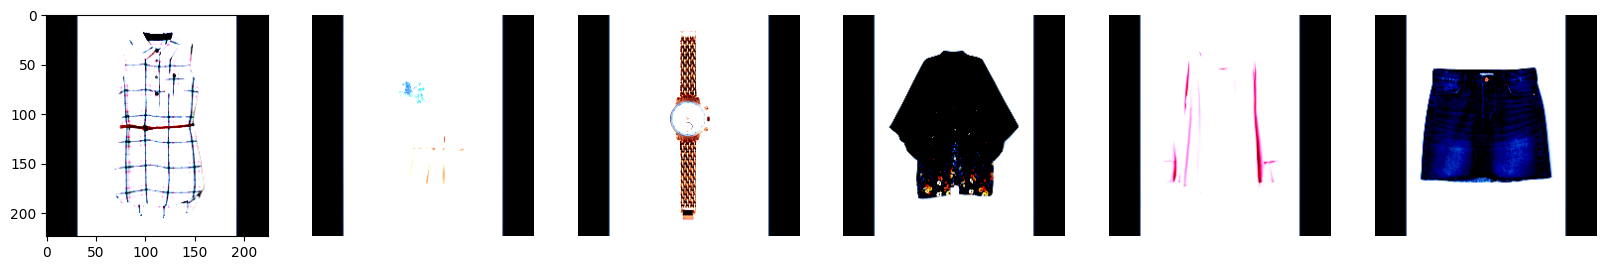

In [63]:
#Plot the images

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 6, figsize=(20, 20))
#plot the common point image
axs[0].imshow(img.permute(1, 2, 0))
#plot the tabular data images knn
for i, img in enumerate(imgs_knn_tab):
    axs[i+1].imshow(img.permute(1, 2, 0))
    axs[i+1].axis('off')
plt.show()

In [65]:
#Plot the images
if len(index_img) > 1:
    fig, axs = plt.subplots(1, 6, figsize=(20, 20))
    #plot the common point image
    axs[0].imshow(img.permute(1, 2, 0))
    #plot the img data images knn
    for i, img in enumerate(imgs_knn_img):
        axs[i].imshow(img)
        axs[i].axis('off')
    plt.show()
else:
    print('No similar images found')

No similar images found
